# Introduction

# Libraries

In [3]:
import requests
import os
import pandas as pd
pd.options.display.max_columns = None
import seaborn as sns
sns.set_style('dark')
pal = 'crest'
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import statsmodels.stats.multicomp as mc

from sklearn.preprocessing import OrdinalEncoder

# User Definitions

In [5]:
edu_order = [
    'No Formal quals',
    'Lower Than A Level',
    'A Level or Equivalent',
    'HE Qualification',
    'Post Graduate Qualification'
]
imd_order = [
    '0-10%',
    '10-20%',
    '20-30%',
    '30-40%',
    '40-50%',
    '50-60%',
    '60-70%',
    '70-80%',
    '80-90%',
    '90-100%'
]
age_order = [
    '0-35',
    '35-55',
    '55<='
]

# Data

https://www.kaggle.com/datasets/thedevastator/open-university-learning-analytics-dataset?resource=download


In [7]:
assess = pd.read_csv('./data/assessments.csv', na_values = '?', low_memory = False)
courses = pd.read_csv('./data/courses.csv', na_values = '?', low_memory = False)
stassess = pd.read_csv('./data/studentAssessment.csv', na_values = '?', low_memory = False)
stinfo = pd.read_csv('./data/studentInfo.csv', na_values = '?', low_memory = False)
streg = pd.read_csv('./data/studentRegistration.csv', na_values = '?', low_memory = False)
stvle = pd.read_csv('./data/studentVle.csv', na_values = '?', low_memory = False)
vle = pd.read_csv('./data/vle.csv', na_values = '?', low_memory = False)

In [8]:
ls_all_docs = [assess, courses, stassess, stinfo, streg, stvle, vle]
assess.name = 'assess'
courses.name = 'courses'
stassess.name = 'stassess'
stinfo.name = 'stinfo'
streg.name = 'streg'
stvle.name = 'stvle'
vle.name = 'vle'

In [9]:
for doc in ls_all_docs:
    print(f'{doc.name}: {doc.shape}')
    print(doc.head(), '\n')
    print(doc.info(), '\n')
    print(doc.describe(), '\n')
    print(doc.isna().sum(), '\n')
    print('------------------------------------------- \n')

assess: (206, 6)
  code_module code_presentation  id_assessment assessment_type   date  weight
0         AAA             2013J           1752             TMA   19.0    10.0
1         AAA             2013J           1753             TMA   54.0    20.0
2         AAA             2013J           1754             TMA  117.0    20.0
3         AAA             2013J           1755             TMA  166.0    20.0
4         AAA             2013J           1756             TMA  215.0    30.0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        206 non-null    object 
 1   code_presentation  206 non-null    object 
 2   id_assessment      206 non-null    int64  
 3   assessment_type    206 non-null    object 
 4   date               195 non-null    float64
 5   weight             206 non-null    float64
dtypes: float64(2), int64

# Data Pre-Cleaning

In [11]:
assess2 = assess.copy()
assess2['date'] = assess2['date'].fillna(assess2['date'].max())

In [12]:
stassess2 = stassess.dropna()

In [13]:
stinfo2 = stinfo.copy()
stinfo2.loc[(stinfo2['imd_band'] == '10-20'), 'imd_band'] = stinfo2['imd_band'] + '%'
most_common = stinfo2['imd_band'].mode()[0]
stinfo3 = stinfo2.copy()
stinfo3['imd_band'].fillna(value = most_common, inplace = True)

In [14]:
streg2 = streg.drop(columns = 'date_unregistration')
streg3 = streg2.dropna()

In [15]:
vle2 = vle.drop(columns = ['week_from', 'week_to'])

# Merging

In [17]:
as_co = assess2.merge(courses, on = ['code_module', 'code_presentation'])
sta_ac = stassess2.merge(as_co, on = 'id_assessment')
in_re = stinfo3.merge(streg3, on = ['code_module', 'code_presentation', 'id_student'])
sv_vl = stvle.merge(vle2, on = ['id_site', 'code_module', 'code_presentation'])
sacri = sta_ac.merge(in_re, on = ['code_module', 'code_presentation', 'id_student'])
df1 = sv_vl.merge(sacri, on = ['code_module', 'code_presentation', 'date', 'id_student'])

# Cleaning

In [19]:
col_order = ['id_student','gender', 'disability', 'age_band', 
             'region', 'imd_band', 'highest_education', 'id_site', 
             'code_module', 'code_presentation', 'id_assessment', 
             'date_registration', 'num_of_prev_attempts', 
             'studied_credits', 'date_submitted', 'score',
             'assessment_type', 'module_presentation_length', 
             'weight', 'is_banked',  'activity_type', 'date',
             'sum_click','final_result']
df2 = df1[col_order]

In [20]:
gender = {'M': 0, 'F': 1}
disability = {'N': 0, 'Y': 1}
df3 = df2.copy()
df3['gender'].replace(gender, inplace = True)
df3['disability'].replace(disability, inplace = True)

In [21]:
df4 = df3.drop_duplicates().reset_index(drop = True)

In [22]:
numeric_names = ['studied_credits', 'weight', 'sum_click', 'date_registration']
df5 = df4.copy()
for col in numeric_names:
    lower = df5[col].quantile(0.025)
    upper = df5[col].quantile(0.975)
    df5 = df5[(df5[col] >= lower) & (df5[col] <= upper)]

While 'date' is a duration length relative to the start of the module, it only serves as a marker for each day of interaction with each activity the students interacted with per assessment. For this reason, 'date' will be aggregated as a count of the number of days interacting with the material. This may quantify the level interaction with each activity type.

Similarly, 'sum_click' is the number of clicks per recorded day. Since the reference date will be removed by the aggregation, 'sum_click' will be aggregated to the total number of clicks per activity to retain the nature of the feature.

In [24]:
new_click_cols = df5.groupby(['id_assessment', 'id_student', 'activity_type']).agg(
    days_active = ('date', 'count'),
    total_clicks = ('sum_click', 'sum')
)
new_clicks = new_click_cols.reset_index()
df6 = df5.merge(new_clicks, on = ['id_assessment', 'id_student', 'activity_type'])

The 'date_submitted' column is a numeric feature that indicates the date the assessment was submitted since the start of the module. Unlike 'date' which served as a reference marker for interactions, this date can be used as more of a duration than marker. Changing the name is more for the user experience to avoid future confusion.

In [26]:
df7 = df6.rename(columns = {'date_submitted': 'assessment_duration'})

* Since 'date' and 'sum_click' both have already been aggregated earlier in df6, these two columns will be dropped.
* Additionally, 'is_banked' is more of an administrative feature that is neither a direct identifier of the student nor is it the direct result of the students' actions. Analyzing whether or not an assessment of the student's will reduce the focus in the model away from the more likely predictors of student success for this program.
* Lastly, 'weight', 'code_module', 'code_presentation', and 'id_site' are all characteristics of 'id_assessment'. These characteristic features will be dropped since they will still have representation through the 'id_assessment'.
* Although 'module_presentation_length' is a numeric feature, it will be removed from consideration for similar reasons as 'weight'; also duration per assessment is already being considered in 'assessment_duration'.

In [28]:
df8 = df7.drop(columns = [
    'date', 'sum_click', 'is_banked',
    'weight', 'module_presentation_length',
    'code_module', 'code_presentation',
    'id_site', 'assessment_type'
])

In [29]:
assess_col = df8.groupby(['id_student']).agg(
    mean_score = ('score', 'mean'),
    mean_assessment_length = ('assessment_duration', 'mean'),
    max_assessment_length = ('assessment_duration', 'max')
)
assess_col.reset_index(inplace = True)

act_col = df8.groupby(['id_student', 'activity_type']).agg(
    mean_active = ('days_active', 'mean'),
    total_active = ('days_active', 'sum'),
    mean_clicks = ('total_clicks', 'mean'),
    clicks = ('total_clicks', 'sum')
)
act_col.reset_index(inplace = True)

df9 = df8.merge(assess_col, on = 'id_student') \
    .merge(act_col, on = ['id_student', 'activity_type'])

In [30]:
df10 = df9.drop(columns = ['id_assessment', 'days_active', 'total_clicks', 'score', 'assessment_duration'])

In [35]:
df11 = df10.drop_duplicates()

# EDA

In [39]:
print(df11.shape)
print(df11.head())
print(df11.info())
print(df11.describe())

(88846, 19)
    id_student  gender  disability age_band             region imd_band  \
0      2412002       0           0    35-55  South West Region   50-60%   
3      2412002       0           0    35-55  South West Region   50-60%   
6      2412002       0           0    35-55  South West Region   50-60%   
9      2412002       0           0    35-55  South West Region   50-60%   
14     2412002       0           0    35-55  South West Region   50-60%   

     highest_education  date_registration  num_of_prev_attempts  \
0   Lower Than A Level              -38.0                     0   
3   Lower Than A Level              -38.0                     0   
6   Lower Than A Level              -38.0                     0   
9   Lower Than A Level              -38.0                     0   
14  Lower Than A Level              -38.0                     0   

    studied_credits activity_type final_result  mean_score  \
0                90       forumng  Distinction      85.125   
3         

One of the most important predictors that would dictate a student's final result is how well they scored on average with their assessments. The score distributions for each of the four results are shown below.

C:\Users\jacob\AppData\Local\Temp\ipykernel_13936\2127677517.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = df11[df11['final_result'] == 'Distinction'], x = 'mean_score', palette = pal, ax = ax[0, 0]).set_title('Distinction')
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jacob\AppData\Local\Temp\ipykernel_13936\2127677517.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = df11[df11['final_result'] == 'Pass'], x = 'mean_score', palette = pal, ax = ax[0, 1]).set_title('Pass')
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values t

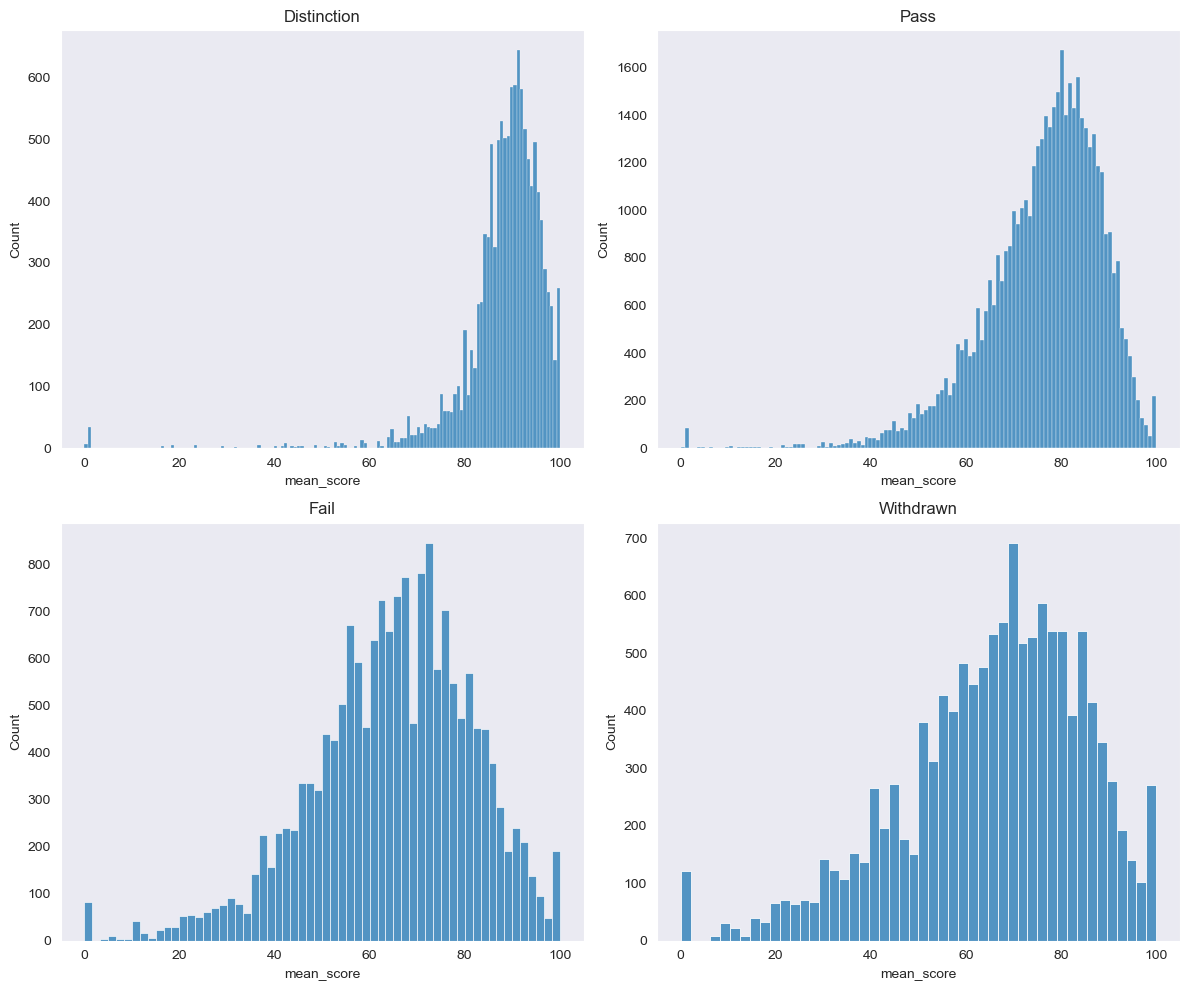

In [41]:
fig, ax = plt.subplots(2, 2, figsize = (12, 10))
sns.histplot(data = df11[df11['final_result'] == 'Distinction'], x = 'mean_score', palette = pal, ax = ax[0, 0]).set_title('Distinction')
sns.histplot(data = df11[df11['final_result'] == 'Pass'], x = 'mean_score', palette = pal, ax = ax[0, 1]).set_title('Pass')
sns.histplot(data = df11[df11['final_result'] == 'Fail'], x = 'mean_score', palette = pal, ax = ax[1, 0]).set_title('Fail')
sns.histplot(data = df11[df11['final_result'] == 'Withdrawn'], x = 'mean_score', palette = pal, ax = ax[1, 1]).set_title('Withdrawn')
plt.tight_layout()
plt.show()

In [47]:
comp1 = mc.MultiComparison(df11['mean_score'], df11['final_result'])
tbl_scr, a1_scr, a2_scr = comp1.allpairtest(stats.ttest_ind, alpha = 0.05, method = 'bonf')
tbl_scr

group1,group2,stat,pval,pval_corr,reject
Distinction,Fail,137.4976,0.0,0.0,True
Distinction,Pass,98.4631,0.0,0.0,True
Distinction,Withdrawn,115.9946,0.0,0.0,True
Fail,Pass,-94.4053,0.0,0.0,True
Fail,Withdrawn,-3.8298,0.0001,0.0008,True
Pass,Withdrawn,75.4599,0.0,0.0,True


In [ ]:
dist_mean = df4[df4['final_result'] == 'Distinction']['score'].mean()
dist_std = df4[df4['final_result'] == 'Distinction']['score'].std()
pass_mean = df4[df4['final_result'] == 'Pass']['score'].mean()
pass_std = df4[df4['final_result'] == 'Pass']['score'].std()
fail_mean = df4[df4['final_result'] == 'Fail']['score'].mean()
fail_std = df4[df4['final_result'] == 'Fail']['score'].std()
with_mean = df4[df4['final_result'] == 'Withdrawn']['score'].mean()
with_std = df4[df4['final_result'] == 'Withdrawn']['score'].std()

print(f'Distinction: {dist_mean} +- {dist_std}')
print(f'Pass: {pass_mean} +- {pass_std}')
print(f'Fail: {fail_mean} +- {fail_std}')
print(f'Withdrawn: {with_mean} +- {with_std}')

Notably, the scores between the four final results have roughly the same mean. Because this is initial exploratory analysis, the data has not yet been normalized so the t-test results will be reassessed after modeling. The key factor that may distinguish the four groups is the sample sizes of each group that impact the variances